In [28]:
import os

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from xarray.coding.cftime_offsets import MonthEnd



In [29]:
home_dir = os.path.expanduser('~')
file_path = os.path.join(home_dir, 'Code/star-struck/data/download.grib')

In [30]:
def load_dataset(filename):
    """
    Load a dataset from a given file path.

    Parameters:
    - filename (str): The path to the dataset file.

    Returns:
    - xarray.Dataset: The loaded dataset with temperature in Celsius.
    """

    home_dir = os.path.expanduser('~')
    file_path = os.path.join(home_dir, 'Code/star-struck/data/', filename)

    ds = xr.open_dataset(file_path, engine='cfgrib')
    
    # convert Kelvin to Celcius
    ds['t2m'] -= 273.15

    return ds

**Explore Dataset**

Load dataset and explore coordinates.

In [31]:
ds = load_dataset(file_path)

print("\n----- Dataset -----\n")
print(ds)

print("\n----- Latitude & Longitude Coordinate -----\n")
print(ds.latitude)
print("\n----\n")
print(ds.longitude)

print("\n----- Datetime Coordinate -----\n")
print(ds.time)
print("\n----\n")
print(ds.step)

print(ds.t2m)


----- Dataset -----

<xarray.Dataset>
Dimensions:     (time: 32, step: 24, latitude: 70, longitude: 103)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2022-06-30 2022-07-01 ... 2022-07-31
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
    surface     float64 ...
  * latitude    (latitude) float64 41.7 41.6 41.5 41.4 ... 35.1 35.0 34.9 34.8
  * longitude   (longitude) float64 19.37 19.47 19.57 ... 29.37 29.47 29.57
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    t2m         (time, step, latitude, longitude) float32 nan nan ... nan nan
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-08-19T02:38 GRIB to CDM+CF via cfgrib-0.

In [32]:
ds.mean(dim='time')

<xarray.Dataset>
Dimensions:    (step: 24, latitude: 70, longitude: 103)
Coordinates:
    number     int64 ...
  * step       (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
    surface    float64 ...
  * latitude   (latitude) float64 41.7 41.6 41.5 41.4 ... 35.1 35.0 34.9 34.8
  * longitude  (longitude) float64 19.37 19.47 19.57 19.67 ... 29.37 29.47 29.57
Data variables:
    t2m        (step, latitude, longitude) float32 nan nan nan ... nan nan nan

***Testing plots***

In [33]:
# Using isel to select the date inde
temp1d = ds.t2m.isel(longitude=5, latitude=5, step=5)
print(temp1d)

<xarray.DataArray 't2m' (time: 32)>
array([      nan, 25.889313, 26.871979, 27.3732  , 26.878815, 27.035065,
       26.250397, 25.324371, 23.973053, 20.818268, 20.271149, 21.964996,
       21.170074, 21.468658, 21.83731 , 23.737946, 25.43692 , 26.024078,
       25.254303, 24.248444, 24.536285, 25.00943 , 25.817291, 26.766266,
       27.037994, 26.40274 , 26.90152 , 26.771393, 26.87857 , 25.699615,
       25.568512, 24.389313], dtype=float32)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2022-06-30 2022-07-01 ... 2022-07-31
    step        timedelta64[ns] 06:00:00
    surface     float64 ...
    latitude    float64 41.2
    longitude   float64 19.87
    valid_time  (time) datetime64[ns] ...
Attributes: (12/30)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      7210
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           

***Testing visualization***

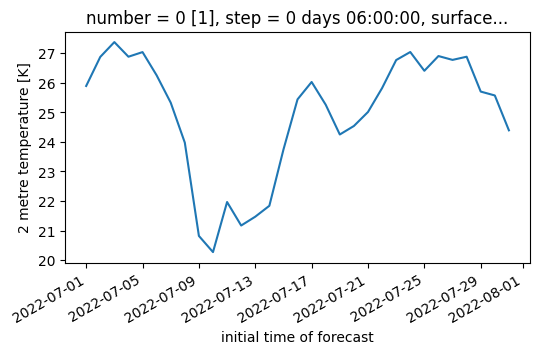

In [34]:
temp1d.plot(aspect=2, size=3)

**Determine x-axis values**

Per default dimension coordinates are used for the x-axis (here the time coordinates). However, you can also use non-dimension coordinates, MultiIndex levels, and dimensions without coordinates along the x-axis. 

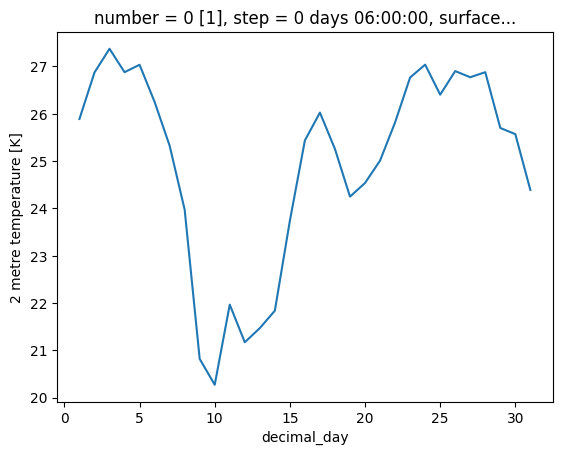

In [35]:
# Create a 'decimal day' (epoch) from the time and assign it as a non-dimension coordinate

decimal_day = (temp1d.time - temp1d.time[0]) / pd.Timedelta("1d")

temp1d_multi = temp1d.assign_coords(decimal_day=("time", decimal_day.data))

temp1d_multi.plot(x="decimal_day")

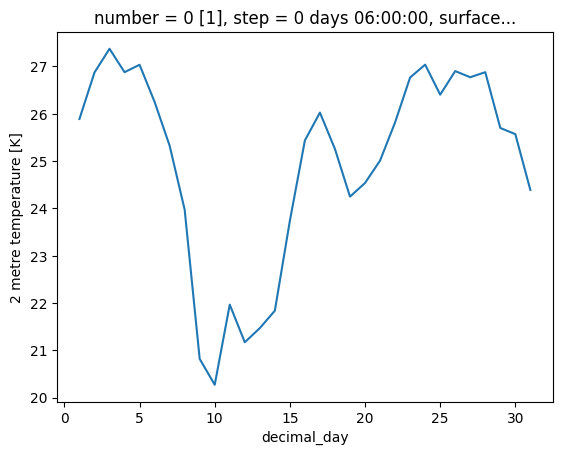

In [36]:
temp1d_multi = temp1d_multi.set_index(date=("time", "decimal_day"))

temp1d_multi.plot(x="decimal_day")

**Multiple lines showing variation along a dimension**

It is possible to make line plots of two-dimensional data by calling xarray.plot.line() with appropriate arguments. Consider the 3D variable air defined above. We can use line plots to check the variation of air temperature at three different latitudes along a longitude line:

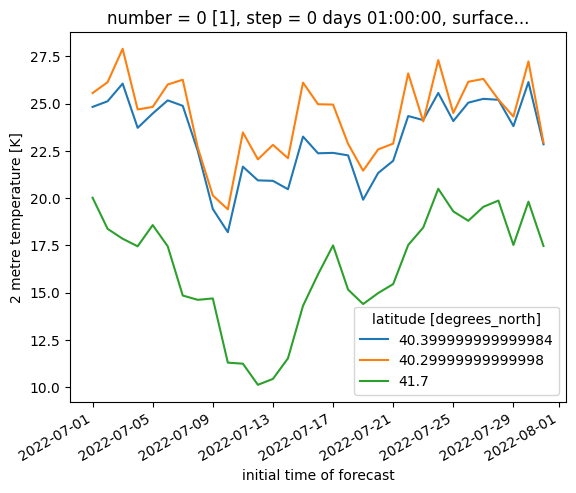

In [52]:
temperature = ds.t2m
temperature_across_lats = temperature.sel(longitude=22.57, latitude=[40.4, 40.3, 45], step='3600000000000', method='nearest')
temperature_across_lats.plot.line(x='time')

**Dimension along y-axis**

It is also possible to make line plots such that the data are on the x-axis and a dimension is on the y-axis. This can be done by specifying the appropriate y keyword argument.

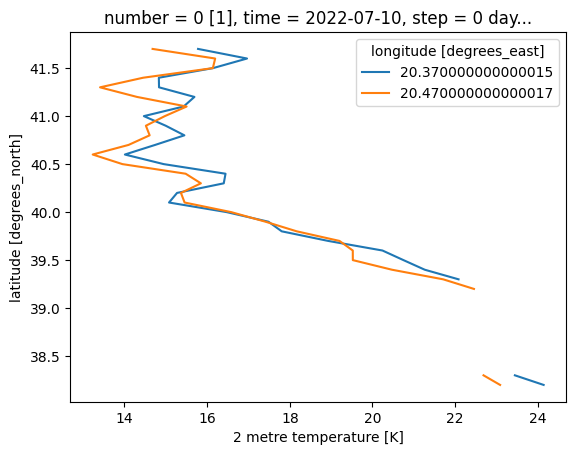

In [54]:
temperature.isel(step= 5, time=10, longitude=[10, 11]).plot(y="latitude", hue="longitude")

**Step plots**

As an alternative, also a step plot similar to matplotlib’s plt.step can be made using 1D data.

The argument where defines where the steps should be placed, options are 'pre' (default), 'post', and 'mid'.

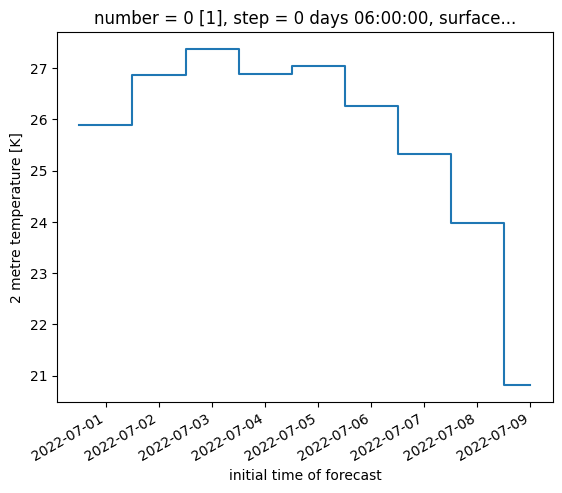

In [56]:
temp1d[:10].plot.step(where="mid")

The argument where defines where the steps should be placed, options are 'pre' (default), 'post', and 'mid'. This is particularly handy when plotting data grouped with Dataset.groupby_bins().

[26.003036 25.38686  25.09826 ]


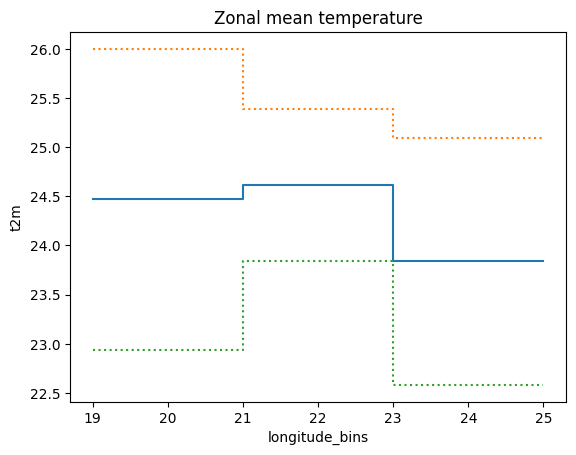

In [74]:
temp_group = ds.t2m.mean(["time", "step", "latitude"]).groupby_bins("longitude", [19, 21, 23, 25])

temp_mean = temp_group.mean()


# get standard deviation
temp_std = temp_group.std()

temp_mean.plot.step()

(temp_mean + temp_std).plot.step(ls=":")

(temp_mean - temp_std).plot.step(ls=":")

plt.title("Zonal mean temperature")

print(t.values)

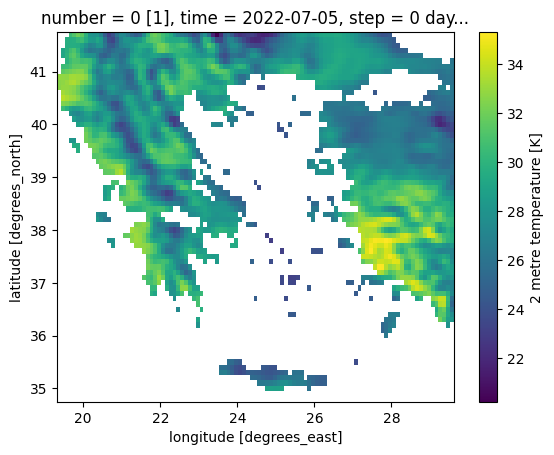

In [77]:
temperature2d = ds.t2m.isel(time=5, step=8)

temperature2d.plot()

/var/folders/m7/4kg77tbd1vqdl_gq34jt0xkr0000gn/T/ipykernel_4478/1891514514.py:4: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  temperature2dtime['step'] = temperature2dtime['step'].astype('timedelta64[h]').astype(float)


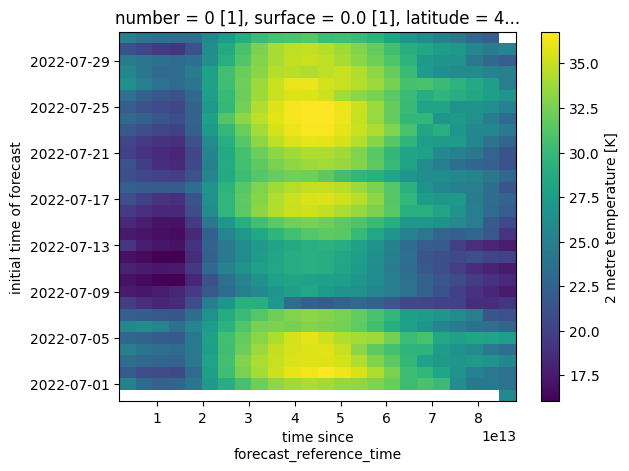

In [86]:
temperature2dtime = ds.t2m.isel(longitude=5, latitude=8)

# convert step to hour
temperature2dtime['step'] = temperature2dtime['step'].astype('timedelta64[h]').astype(float)

temperature2dtime.plot()

**Calling Matplotlib**

Since xarray provides a thin wrapper around matplotlib, all the functionality of matplotlib is available.

/var/folders/m7/4kg77tbd1vqdl_gq34jt0xkr0000gn/T/ipykernel_4478/2455448359.py:4: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  testing_matplot['step'] = testing_matplot['step'].astype('timedelta64[h]').astype(float)


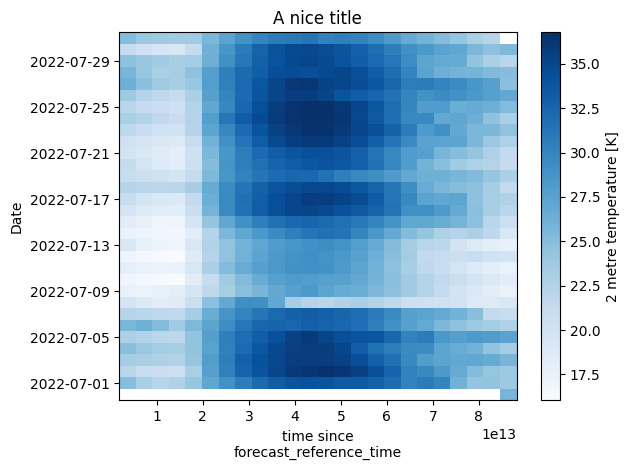

In [88]:
testing_matplot = ds.t2m.isel(longitude=5, latitude=8)

# convert step to hour
testing_matplot['step'] = testing_matplot['step'].astype('timedelta64[h]').astype(float)

testing_matplot.plot(cmap=plt.cm.Blues)

plt.title("A nice title")

plt.ylabel("Time in hours")

plt.ylabel("Date")

plt.tight_layout()

plt.draw()

**Drawing maps**

/Users/dimly/Code/star-struck/env/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


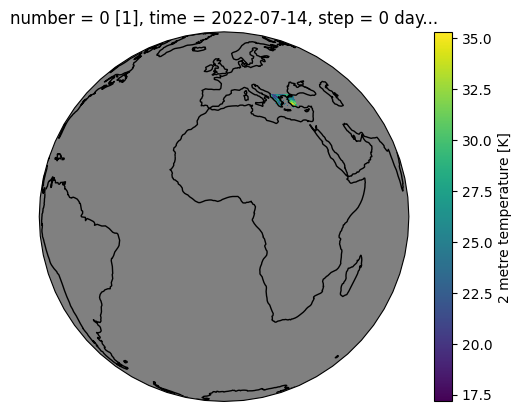

In [93]:
import cartopy.crs as ccrs

p = ds.t2m.isel(time=14, step=9).plot(
subplot_kws=dict(projection=ccrs.Orthographic(), facecolor="gray"), transform=ccrs.PlateCarree(),)

p.axes.set_global()

p.axes.coastlines()